# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [2]:
colab = False  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../data/anime/rating.csv.zip')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет. 

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут. 

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее. 

### 1. Избавьтесь от -1

In [5]:
###  Ваш код  ###

ratings['rating'] =  ratings['rating']. replace (-1, np.nan)
ratings

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN
...,...,...,...
7813732,73515,16512,7.0
7813733,73515,17187,9.0
7813734,73515,22145,10.0
7813735,73516,790,9.0


## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn. 

In [6]:
from scipy.special import erfc

def chauvenet(array):
    
    mean = np.mean(array, axis=0)
    column_deviations = np.std(array, axis=0) 
    num_non_nan = array.count()
    mask = erfc(abs(array - mean) / column_deviations ) < ( 1 / (2 * num_non_nan))
    
    print(mean)
    print(column_deviations)
    print(num_non_nan)
 
 
    return mask

mask = chauvenet(ratings)

print(mask.rating.value_counts())

mask

user_id     36727.956745
anime_id     8909.072104
rating          7.808497
dtype: float64
user_id     20997.944775
anime_id     8883.949067
rating          1.572496
dtype: float64
user_id     7813737
anime_id    7813737
rating      6337241
dtype: int64
rating
False    7797088
True       16649
Name: count, dtype: int64


,user_id,anime_id,rating
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
7813732,False,False,False
7813733,False,False,False
7813734,False,False,False
7813735,False,False,False


Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [7]:
###  Ваш код  ### 

count_reviews = ratings.groupby('user_id')['anime_id'].apply ( lambda x: ( x!=0 ).sum()).reset_index(name='count')

count_reviews = count_reviews.set_index('user_id')

count_reviews


,count
user_id,
1,153
2,3
3,94
4,52
5,467
...,...
73512,13
73513,33
73514,1


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [8]:
###  Ваш код  ### 
outlier_users =  count_reviews[chauvenet(count_reviews)]
outlier_users = outlier_users.dropna (how='all')
outlier_users = outlier_users.sort_values(by='count')
outlier_users


count    106.287656
dtype: float64
count    153.085517
dtype: float64
count    73515
dtype: int64


,count
user_id,
35595,594.0
40547,594.0
52366,594.0
52420,594.0
21044,594.0
...,...
59643,2633.0
57620,2702.0
53698,2905.0


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?


#### Почему критерий посчитал их выбросом?


#### Нужна ли им вообще рекомендательная система?



**Ответы:**

Пользователей с количествои просмотренных аниме больше или равно 594


Остальные пользователи посмотрели сильно меньше


Да, нужна. Рекомендации могут помочь пользователям открывать новые аниме, которые им могут понравиться, на основе их предпочтений, оценок и просмотров. 

In [9]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

count    594.0
dtype: float64

Если все было правильно `bad_user_threshold` больше 500. 

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [10]:
###  Ваш код  ### 
count_reviews = count_reviews.rename(columns={'count': 'count_reviews'})

ratings = pd.merge(ratings, count_reviews, left_on='user_id', right_on='user_id')

ratings = ratings[ratings.count_reviews < int(bad_user_threshold)]

ratings

C:\Users\Алёна\AppData\Local\Temp\ipykernel_12740\1180302502.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ratings = ratings[ratings.count_reviews < int(bad_user_threshold)]


,user_id,anime_id,rating,count_reviews
0,1,20,NaN,153
1,1,24,NaN,153
2,1,79,NaN,153
3,1,226,NaN,153
4,1,241,NaN,153
...,...,...,...,...
7813732,73515,16512,7.0,196
7813733,73515,17187,9.0,196
7813734,73515,22145,10.0,196
7813735,73516,790,9.0,2


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [11]:
###  Ваш код  ### 
ratings = ratings[ratings.count_reviews >= ratings['count_reviews'].median()]
ratings


,user_id,anime_id,rating,count_reviews
302,5,6,8.0,467
303,5,15,6.0,467
304,5,17,6.0,467
305,5,18,6.0,467
306,5,20,6.0,467
...,...,...,...,...
7813730,73515,13659,8.0,196
7813731,73515,14345,7.0,196
7813732,73515,16512,7.0,196
7813733,73515,17187,9.0,196


In [12]:
# Удалим столбец с просмотрами чтобы не мешал.

ratings = ratings.drop(columns=['count_reviews'])
ratings

,user_id,anime_id,rating
302,5,6,8.0
303,5,15,6.0
304,5,17,6.0
305,5,18,6.0
306,5,20,6.0
...,...,...,...
7813730,73515,13659,8.0
7813731,73515,14345,7.0
7813732,73515,16512,7.0
7813733,73515,17187,9.0


Теперь рассмотрим таблицу `anime`. 


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [13]:
###  Ваш код  ### 

outlier_anime =  anime[['rating']][chauvenet(anime[['rating']])]
outlier_anime = outlier_anime.dropna (how='all')
outlier_anime.sort_values(by='rating', ascending=False)

rating    6.478264
dtype: float64
rating    1.023814
dtype: float64
rating    12017
dtype: int64


,rating
anime_id,
33662,10.00
30120,9.60
23005,9.50
29856,3.51
33861,3.50
...,...
413,2.37
13405,2.14
3287,2.00


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом? 


#### Почему критерий посчитал их выбросом? 


#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе? 


**Ответы:**

Аниме с рейтингом выше 9.5 и с рейтингом ниже 3.51.


Эти значения очень редко встречаются и находятся на границах доступных значений. 


Да, аниме очень низким рейтингом не стоит никому рекомендовать. 

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы. 

In [14]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [15]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports'
 'Action, Adventure, Shounen, Super Power'
 'Drama, Military, Sci-Fi, Space'
 'Drama, Fantasy, Romance, Slice of Life, Supernatural'
 'Drama, School, Shounen'
 'Action, Drama, Mecha, Military, Sci-Fi, Super Power']
len= 3229

Genres=['Yaoi', 'Demons', 'Samurai', 'Psychological', 'Game', 'Historical', 'Ecchi', 'Dementia', 'Romance', 'Sports', 'Super Power', 'Mecha', 'Horror', 'Supernatural', 'School', 'Vampire', 'Adventure', 'Slice of Life', 'Shounen Ai', 'Seinen', 'Mystery', 'Comedy', 'Thriller', 'Magic', 'Harem', 'Yuri', 'Cars', 'Police', 'Action', 'Sci-Fi', 'Music', 'Shounen', 'Fantasy', 'Kids', 'Josei', 'Shoujo Ai', 'Parody', 'Shoujo', 'Drama', 'Military', 'Space', 'Hentai', 'Martial Arts']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [16]:
###  Ваш код  ### 
anime_genres = pd.DataFrame(columns=genres, index = anime.index)

for index, row in anime.iterrows():
    genres_ = row['genre'].split(', ')
    for genre in genres_:
       anime_genres.loc[index, genre] = 1

anime_genres = anime_genres.fillna(0)

anime_genres

,Yaoi,Demons,Samurai,Psychological,Game,Historical,Ecchi,Dementia,Romance,Sports,...,Kids,Josei,Shoujo Ai,Parody,Shoujo,Drama,Military,Space,Hentai,Martial Arts
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
28977,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9969,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [17]:
###  Ваш код  ###  

df = pd.merge(ratings, anime_genres, on='anime_id')
df

,user_id,anime_id,rating,Yaoi,Demons,Samurai,Psychological,Game,Historical,Ecchi,...,Kids,Josei,Shoujo Ai,Parody,Shoujo,Drama,Military,Space,Hentai,Martial Arts
0,5,6,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,129,6,9.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,160,6,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,235,6,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,250,6,9.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412062,72800,30738,4.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3412063,72884,9239,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3412064,73114,5550,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3412065,73247,25857,7.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [18]:
###  Ваш код  ### 

df = df.drop(columns='anime_id')
df = df.groupby('user_id').mean(numeric_only=True)
df = df.drop(columns='rating')
df

,Yaoi,Demons,Samurai,Psychological,Game,Historical,Ecchi,Dementia,Romance,Sports,...,Kids,Josei,Shoujo Ai,Parody,Shoujo,Drama,Military,Space,Hentai,Martial Arts
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.042827,0.025696,0.029979,0.021413,0.034261,0.214133,0.002141,0.334047,0.085653,...,0.038544,0.004283,0.002141,0.044968,0.014989,0.167024,0.008565,0.008565,0.000000,0.055675
7,0.0,0.069971,0.005831,0.069971,0.043732,0.014577,0.224490,0.008746,0.379009,0.034985,...,0.011662,0.000000,0.008746,0.046647,0.032070,0.139942,0.026239,0.000000,0.000000,0.017493
38,0.0,0.063241,0.023715,0.071146,0.035573,0.055336,0.146245,0.007905,0.221344,0.031621,...,0.000000,0.007905,0.003953,0.023715,0.007905,0.205534,0.055336,0.015810,0.000000,0.027668
43,0.0,0.070423,0.042254,0.063380,0.017606,0.091549,0.214789,0.000000,0.257042,0.017606,...,0.000000,0.000000,0.007042,0.028169,0.024648,0.161972,0.045775,0.003521,0.000000,0.049296
46,0.0,0.047904,0.035928,0.059880,0.035928,0.080838,0.062874,0.000000,0.290419,0.065868,...,0.005988,0.050898,0.002994,0.041916,0.149701,0.218563,0.053892,0.005988,0.000000,0.017964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73491,0.0,0.049275,0.023188,0.023188,0.002899,0.078261,0.176812,0.000000,0.434783,0.011594,...,0.000000,0.014493,0.028986,0.046377,0.095652,0.301449,0.040580,0.020290,0.017391,0.037681
73502,0.0,0.025490,0.005882,0.064706,0.013725,0.021569,0.170588,0.005882,0.356863,0.021569,...,0.001961,0.021569,0.003922,0.060784,0.013725,0.256863,0.039216,0.000000,0.000000,0.027451
73503,0.0,0.089431,0.036585,0.126016,0.028455,0.109756,0.052846,0.012195,0.272358,0.008130,...,0.000000,0.016260,0.000000,0.008130,0.056911,0.365854,0.077236,0.032520,0.000000,0.040650


Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [19]:
###  Ваш код  ### 
df.fillna(-1)
df.head()

,Yaoi,Demons,Samurai,Psychological,Game,Historical,Ecchi,Dementia,Romance,Sports,...,Kids,Josei,Shoujo Ai,Parody,Shoujo,Drama,Military,Space,Hentai,Martial Arts
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.042827,0.025696,0.029979,0.021413,0.034261,0.214133,0.002141,0.334047,0.085653,...,0.038544,0.004283,0.002141,0.044968,0.014989,0.167024,0.008565,0.008565,0.0,0.055675
7,0.0,0.069971,0.005831,0.069971,0.043732,0.014577,0.224490,0.008746,0.379009,0.034985,...,0.011662,0.000000,0.008746,0.046647,0.032070,0.139942,0.026239,0.000000,0.0,0.017493
38,0.0,0.063241,0.023715,0.071146,0.035573,0.055336,0.146245,0.007905,0.221344,0.031621,...,0.000000,0.007905,0.003953,0.023715,0.007905,0.205534,0.055336,0.015810,0.0,0.027668
43,0.0,0.070423,0.042254,0.063380,0.017606,0.091549,0.214789,0.000000,0.257042,0.017606,...,0.000000,0.000000,0.007042,0.028169,0.024648,0.161972,0.045775,0.003521,0.0,0.049296
46,0.0,0.047904,0.035928,0.059880,0.035928,0.080838,0.062874,0.000000,0.290419,0.065868,...,0.005988,0.050898,0.002994,0.041916,0.149701,0.218563,0.053892,0.005988,0.0,0.017964


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [20]:
###  Ваш код  ### 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df)
scaler.transform(df)

df

,Yaoi,Demons,Samurai,Psychological,Game,Historical,Ecchi,Dementia,Romance,Sports,...,Kids,Josei,Shoujo Ai,Parody,Shoujo,Drama,Military,Space,Hentai,Martial Arts
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.042827,0.025696,0.029979,0.021413,0.034261,0.214133,0.002141,0.334047,0.085653,...,0.038544,0.004283,0.002141,0.044968,0.014989,0.167024,0.008565,0.008565,0.000000,0.055675
7,0.0,0.069971,0.005831,0.069971,0.043732,0.014577,0.224490,0.008746,0.379009,0.034985,...,0.011662,0.000000,0.008746,0.046647,0.032070,0.139942,0.026239,0.000000,0.000000,0.017493
38,0.0,0.063241,0.023715,0.071146,0.035573,0.055336,0.146245,0.007905,0.221344,0.031621,...,0.000000,0.007905,0.003953,0.023715,0.007905,0.205534,0.055336,0.015810,0.000000,0.027668
43,0.0,0.070423,0.042254,0.063380,0.017606,0.091549,0.214789,0.000000,0.257042,0.017606,...,0.000000,0.000000,0.007042,0.028169,0.024648,0.161972,0.045775,0.003521,0.000000,0.049296
46,0.0,0.047904,0.035928,0.059880,0.035928,0.080838,0.062874,0.000000,0.290419,0.065868,...,0.005988,0.050898,0.002994,0.041916,0.149701,0.218563,0.053892,0.005988,0.000000,0.017964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73491,0.0,0.049275,0.023188,0.023188,0.002899,0.078261,0.176812,0.000000,0.434783,0.011594,...,0.000000,0.014493,0.028986,0.046377,0.095652,0.301449,0.040580,0.020290,0.017391,0.037681
73502,0.0,0.025490,0.005882,0.064706,0.013725,0.021569,0.170588,0.005882,0.356863,0.021569,...,0.001961,0.021569,0.003922,0.060784,0.013725,0.256863,0.039216,0.000000,0.000000,0.027451
73503,0.0,0.089431,0.036585,0.126016,0.028455,0.109756,0.052846,0.012195,0.272358,0.008130,...,0.000000,0.016260,0.000000,0.008130,0.056911,0.365854,0.077236,0.032520,0.000000,0.040650


### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [21]:
### Ваш код ###

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(df)

### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

In [22]:
###  Ваш код  ### 


# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

  0%|          | 0/29 [00:00<?, ?it/s]c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  3%|▎         | 1/29 [00:00<00:05,  5.15it/s]c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  7%|▋         | 2/29 [00:00<00:05,  4.87it/s]c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 10%|█         | 3/29 [00:00<00:05,  4.52it/s

Text(0, 0.5, '$J(C_k)$')

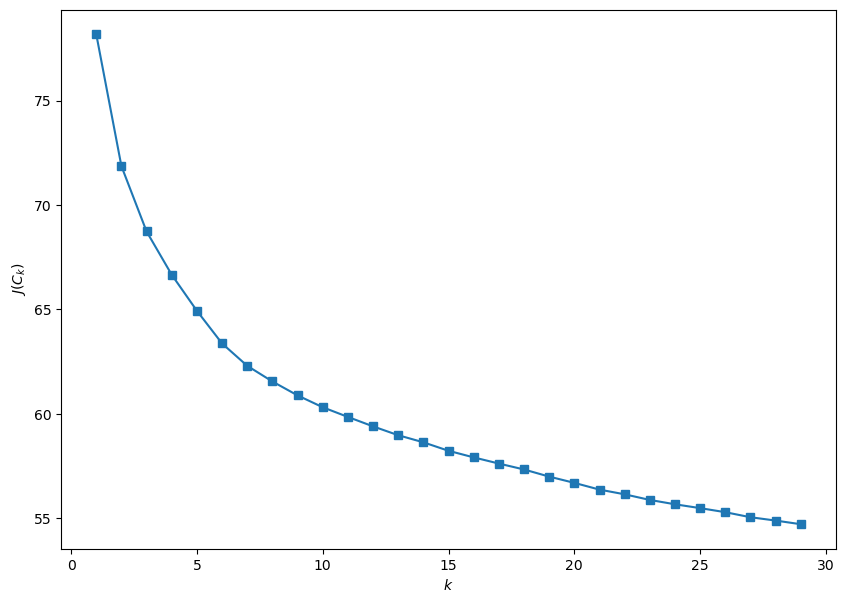

In [23]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. 

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [24]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

  0%|          | 0/28 [00:00<?, ?it/s]c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  4%|▎         | 1/28 [00:01<00:45,  1.67s/it]c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  7%|▋         | 2/28 [00:03<00:43,  1.67s/it]c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 11%|█         | 3/28 [00:05<00:43,  1.74s/it

2

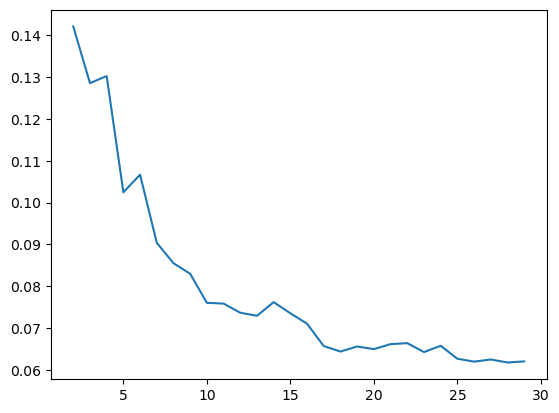

In [25]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

In [26]:
###  Ваш код  ### 

### 18. Порекомендуйте что-нибудь абстрактному пользователю. 
Это можно сделать разными способами. Как это сделать подумайте сами. 

Если затрудняетесь реализовать это в коде, распишите словами как вы бы это сделали.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен. 
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [27]:
###  Ваш код или рассуждение или все вместе ###

### Extra. Попробуйте как-нибудь улучшить эту рекомендашку. Приведите код или рассуждения на эту тему.

Если писать код, то можно:
 * каждому жанру присвоить свой вес, так как одних жанров сильно много и у них разная смысловая нагрузка. Комедии и экшн встречаются очень часто и врядли кто-то только из-за этих жанров будет смотреть аниме.
 * предсказывать не по жанрам, а по аниме. Там получится очень большая размерность, так как нужно сделать one-hot-encoding по аниме, но может это даст лучше результат(спойлер: нет). (И для этого надо сделать 4 join'а, что, возможно, убьет ваш компьютер или/и мозг)

In [28]:
###  Ваш код или рассуждение или все вместе ### 